In [76]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd 
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#### Functions to be used for model and feature selection

In [50]:
### Function to save final model for later use
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

# Function to Fit model based on optimal values of number of estimators and use it to compute feature importance for all the features.
def get_feature_importance(n_tree, max_leaf, X_train, y_train, model_type):
    
    if model_type == 'RF':
        rf_opt = RandomForestClassifier(n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False)

    elif model_type == 'DT':
        rf_opt = DecisionTreeClassifier(max_leaf_nodes=max_leaf, random_state=42)    

    rf_opt.fit(X_train, y_train)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    feature_importance.index = X_train.columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns), axis=0, ascending=False)
    
    return feature_importance


#Function to Fit model based on optimal values of depth and number of estimators and feature importance
# to find the fewest possible features to exceed the previously attained score with all selected features
def get_fewest_features(importance):    
    sorted_feature_names = importance.index
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports


def get_scores(classes, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test,model_type):      
                        
    if model_type == 'RF':
        model = RandomForestClassifier(n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False)

    elif model_type == 'DT':
        model = DecisionTreeClassifier(max_leaf_nodes=max_leaf, random_state=42) 

    model.fit(X_train[feats], y_train)
    y_pred = model.predict(X_test[feats])

    class_report = classification_report(y_test, y_pred, target_names=classes, output_dict = True)
    
    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred


def get_x_y(Dataset, classes, feats):
    Dataset = Dataset[Dataset["label"].isin(classes)]    
    X = Dataset[feats]
    y = Dataset['label'].replace(classes, range(len(classes)))
    return X, y

def analyze_models(classes, model_type, n_trees, X_train, y_train, X_test, y_test, max_leaf, filename_out):
    with open(filename_out, "w") as res_file:
        print('tree;n_feat;macro;weighted;feats', file=res_file)
        if model_type == 'RF':
            # FOR EACH (n_tree, feat)
            for n_tree in n_trees:
                # get feature orders to use
                importance = get_feature_importance(n_tree, max_leaf, X_train, y_train,model_type)
                m_feats = get_fewest_features(importance) 
                for feats in m_feats:
                    # Get the scores with the given (n_tree, feat)
                    model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test,model_type)
                    print(str(n_tree)+';'+str(len(feats))+';'+str(macro_f1)+';'+str(weight_f1)+';'+str(list(feats)), file=res_file)

        elif model_type == 'DT':
            importance = get_feature_importance(0, max_leaf, X_train, y_train,model_type)
            m_feats = get_fewest_features(importance) 
            for feats in m_feats:
                # Get the scores with the given (n_tree, feat)
                model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, 0, feats, max_leaf, X_train, y_train, X_test, y_test,model_type)
                print(str(0)+';'+str(len(feats))+';'+str(macro_f1)+';'+str(weight_f1)+';'+str(list(feats)), file=res_file)
    print("Analysis Complete. Check output file.")
    return []

#### Load cleaned data

In [112]:
# Load the labeled file and print number of rows per label
df_train = pd.read_csv("./TRAIN_DATA_PKT.csv")
df_test = pd.read_csv("./TEST_DATA_PKT.csv")

In [113]:
print(df_train['label'].value_counts())

NORMAL                 1214719
DISABLE_UNSOLICITED     874027
COLD_RESTART            867299
WARM_RESTART            865689
INIT_DATA               102657
STOP_APP                 34320
DNP3_ENUMERATE           30316
DNP3_INFO                26414
REPLAY                    7592
No Label                  2026
MITM_DOS                   120
Name: label, dtype: int64


In [114]:
print(df_test['label'].value_counts())

NORMAL                 398434
WARM_RESTART           288784
COLD_RESTART           287102
DISABLE_UNSOLICITED    280686
INIT_DATA               34073
STOP_APP                11386
DNP3_ENUMERATE           9570
DNP3_INFO                8826
REPLAY                   3101
No Label                  466
Name: label, dtype: int64


In [115]:
# We use 7 representative classes for our analysis
classes = ['NORMAL', 'DISABLE_UNSOLICITED', 'COLD_RESTART', 'WARM_RESTART', 'INIT_DATA', 'REPLAY', 'STOP_APP']

# select data for the 7 classes
df_train = df_train[df_train['label'].isin(classes)]
df_test  = df_test[df_test['label'].isin(classes)]

# Normalize the tcp.hdr_len as it is a 4 bit number in the switch
df_train['tcp.hdr_len'] = df_train['tcp.hdr_len']/4
df_test['tcp.hdr_len'] = df_test['tcp.hdr_len']/4

# features for feature and model selection process
features = ['ip.len', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.fin', 'tcp.flags.reset', 'ip.proto', 'ip.ttl', 'srcport',
       'dstport', 'tcp.window_size_value', 'tcp.hdr_len', 'udp.length']

In [116]:
#we separate the data into features and labels and then numerize the labels
X_train, X_test, y_train, y_test = df_train[features], df_test[features], df_train['label'], df_test['label']

y_train = y_train.replace(classes, range(len(classes)))
y_test = y_test.replace(classes, range(len(classes)))

In [117]:
y_train.value_counts()

0    1214719
1     874027
2     867299
3     865689
4     102657
6      34320
5       7592
Name: label, dtype: int64

In [118]:
y_test.value_counts()

0    398434
3    288784
2    287102
1    280686
4     34073
6     11386
5      3101
Name: label, dtype: int64

#### Analyze the features and model combinations for both DT and RF

In [58]:
analyze_models(classes, "DT", range(1,5,1), X_train, y_train, X_test, y_test, 500, "PKT_models_7_21_02_DT.csv")

Analysis Complete. Check output file.


[]

In [59]:
analyze_models(classes, "RF", range(1,8,2), X_train, y_train, X_test, y_test, 500, "PKT_models_7_21_02_RF.csv")

Analysis Complete. Check output file.


[]

In [60]:
results_dt, results_rf = pd.read_csv("PKT_models_7_21_02_DT.csv", delimiter=";"), pd.read_csv("PKT_models_7_21_02_RF.csv", delimiter=";")
results_dt = results_dt.sort_values(by=['macro','weighted'],ascending=False)
results_rf = results_rf.sort_values(by=['macro','weighted'],ascending=False)

In [61]:
results_dt.head(10)

,tree,n_feat,macro,weighted,feats
3,0,4,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len']"
4,0,5,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
5,0,6,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
6,0,7,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
7,0,8,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
8,0,9,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
9,0,10,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
10,0,11,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
11,0,12,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."
12,0,13,0.986905,0.99958,"['srcport', 'dstport', 'tcp.hdr_len', 'ip.len'..."


In [111]:
results_rf.head(10)

,tree,n_feat,macro,weighted,feats
16,3,4,0.987283,0.999593,"['srcport', 'dstport', 'tcp.window_size_value'..."
3,1,4,0.986625,0.998585,"['srcport', 'dstport', 'tcp.window_size_value'..."
2,1,3,0.985765,0.999545,"['srcport', 'dstport', 'tcp.window_size_value']"
14,3,2,0.985765,0.999545,"['srcport', 'dstport']"
15,3,3,0.985765,0.999545,"['srcport', 'dstport', 'tcp.window_size_value']"
27,5,2,0.985765,0.999545,"['srcport', 'dstport']"
28,5,3,0.985765,0.999545,"['srcport', 'dstport', 'tcp.window_size_value']"
29,5,4,0.985765,0.999545,"['srcport', 'dstport', 'tcp.window_size_value'..."
40,7,2,0.985765,0.999545,"['srcport', 'dstport']"
41,7,3,0.985765,0.999545,"['srcport', 'dstport', 'tcp.window_size_value']"


In [89]:
# performance gap RF - DT: Macro F1
(0.987283 - 0.986905)*100

0.037799999999998946

In [90]:
# performance gap RF - DT: Weighted F1
(0.999593 - 0.99958)*100

0.0012999999999929734

#### Train and save final selected model

In [95]:
# We train the final selected model
# From analysis, DT and RF have similar top scores so we pick DT with 4 features as it is simpler
dt = DecisionTreeClassifier(random_state=42, max_leaf_nodes=500)

# Train the model
dt.fit(X_train[['srcport', 'dstport', 'tcp.hdr_len', 'ip.len']], y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test[['srcport', 'dstport', 'tcp.hdr_len', 'ip.len']])

# Evaluate the model
report = classification_report(y_test, y_pred,target_names=classes, output_dict=True)
print(report)


{'NORMAL': {'precision': 0.9988616190084552, 'recall': 0.9998092532263813, 'f1-score': 0.9993352114654699, 'support': 398434}, 'DISABLE_UNSOLICITED': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 280686}, 'COLD_RESTART': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 287102}, 'WARM_RESTART': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 288784}, 'INIT_DATA': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34073}, 'REPLAY': {'precision': 0.9720896070510466, 'recall': 0.8535956143179619, 'f1-score': 0.9089972527472528, 'support': 3101}, 'STOP_APP': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11386}, 'accuracy': 0.9995934229643916, 'macro avg': {'precision': 0.9958501751513573, 'recall': 0.9790578382206204, 'f1-score': 0.9869046377446746, 'support': 1303566}, 'weighted avg': {'precision': 0.9995856597820748, 'recall': 0.9995934229643916, 'f1-score': 0.9995803251433394, 'support': 1303566}}


In [64]:
# we check the number of bits that the code words will have in P4
nbitsp4 = dt.tree_.node_count - dt.tree_.n_leaves
print("Number of bits in P4: ", nbitsp4)

Number of bits in P4:  111


In [65]:
# save the model for use in p4
save_model(dt, "dt_model_dnp3_7_classes.pkl")

In [93]:
depth = dt.tree_.max_depth
print("Depth of the decision tree:", depth)

Depth of the decision tree: 36


In [97]:
def calculate_scores_fpr_tpr(y_true, y_pred, classes,labels):

    cm = confusion_matrix(y_true, y_pred)
    metrics_table = []

    for i in range(len(classes)):
        TP = cm[i, i]
        FN = sum(cm[i, :]) - TP
        FP = sum(cm[:, i]) - TP
        TN = sum(sum(cm)) - TP - FP - FN

        # precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=[i])
        TPR = (TP / (TP + FN)) if TP + FN != 0 else 0
        FPR = (FP / (FP + TN)) if FP + TN != 0 else 0
        TNR = (TN / (TN + FP)) if TN + FP != 0 else 0
        FNR = (FN / (FN + TP)) if FN + TP != 0 else 0
        f1_score = (2*TP)/((2*TP)+FP+FN)

        metrics_table.append([f1_score, TPR, FPR, TNR, FNR])
    
    metrics_table = np.array(metrics_table)
    macro_avg = np.mean(metrics_table, axis=0)

    weighted_avg = np.average(metrics_table, axis=0, weights=np.sum(cm, axis=1)/np.sum(cm))

    final_met_table = pd.DataFrame(np.vstack((metrics_table, macro_avg, weighted_avg)), columns=['F1 Score', 'TPR', 'FPR', 'TNR', 'FNR'], index=labels + ['Macro Avg', 'Weighted Avg'])

    return cm, final_met_table

In [98]:
classes_long = ['Normal', 'Disable Unsolicited', 'Cold Restart', 'Warm Restart', 'Data Initialization', 'Replay', 'Stop Application']
classes_short = ['Normal', 'Disable', 'Cold', 'Warm', 'Data', 'Replay', 'Stop']

In [100]:
cm, final_met_table = calculate_scores_fpr_tpr(y_test, y_pred, classes,classes_long)

In [104]:
final_met_table*100

,F1 Score,TPR,FPR,TNR,FNR
Normal,99.933521,99.980925,0.050158,99.949842,0.019075
Disable Unsolicited,100.000000,100.000000,0.000000,100.000000,0.000000
Cold Restart,100.000000,100.000000,0.000000,100.000000,0.000000
Warm Restart,100.000000,100.000000,0.000000,100.000000,0.000000
Data Initialization,100.000000,100.000000,0.000000,100.000000,0.000000
Replay,90.899725,85.359561,0.005844,99.994156,14.640439
Stop Application,100.000000,100.000000,0.000000,100.000000,0.000000
Macro Avg,98.690464,97.905784,0.008000,99.992000,2.094216
Weighted Avg,99.958033,99.959342,0.015345,99.984655,0.040658


In [123]:
# visualizing the best RF
rf = RandomForestClassifier(n_estimators=3, random_state=42,bootstrap=False, max_leaf_nodes=500)  

# Train the model
rf.fit(X_train[['srcport', 'dstport', 'tcp.window_size_value', 'ip.len']], y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test[['srcport', 'dstport', 'tcp.window_size_value', 'ip.len']])

# Evaluate the model
report = classification_report(y_test, y_pred_rf,target_names=classes, output_dict=True)
print(report)


{'NORMAL': {'precision': 0.9988716714307206, 'recall': 0.9998393711380053, 'f1-score': 0.9993552870227054, 'support': 398434}, 'DISABLE_UNSOLICITED': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 280686}, 'COLD_RESTART': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 287102}, 'WARM_RESTART': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 288784}, 'INIT_DATA': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34073}, 'REPLAY': {'precision': 0.976427255985267, 'recall': 0.854885520799742, 'f1-score': 0.9116231086657497, 'support': 3101}, 'STOP_APP': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11386}, 'accuracy': 0.999605696988108, 'macro avg': {'precision': 0.996471275345141, 'recall': 0.979246413133964, 'f1-score': 0.9872826279554936, 'support': 1303566}, 'weighted avg': {'precision': 0.9995990509537978, 'recall': 0.999605696988108, 'f1-score': 0.9995927077643763, 'support': 1303566}}


In [124]:
cm_rf, final_met_table_rf = calculate_scores_fpr_tpr(y_test, y_pred_rf, classes,classes_long)

In [127]:
final_met_table_rf.to_csv("final_met_table_rf.csv")

##### Plot of number of samples per class

In [66]:
pkt_data = pd.concat([df_train, df_test])

In [67]:
pkt_data = pkt_data[pkt_data['label'].isin(classes)]

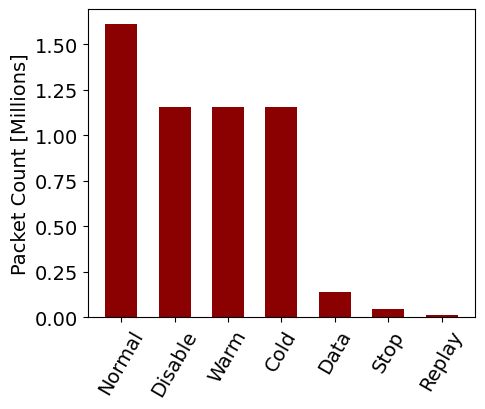

In [94]:
# number of packets per class in data
pkt_data_counts = pkt_data['label'].value_counts()

# bar plots
fig, ax = plt.subplots(figsize=(5, 4))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['lines.linewidth'] = 4

plt.rcParams.update({'font.size': 14, 'axes.labelsize': 14, 'xtick.labelsize': 14, 
                        'ytick.labelsize': 14, 'legend.fontsize': 14, 'lines.linewidth':3})

ax.bar(pkt_data_counts.index, pkt_data_counts.values/(1000000), color='darkred', width=0.6)

ax.set_ylabel('Packet Count [Millions]')

ax.set_xticklabels(['Normal', 'Disable', 'Warm', 'Cold', 'Data', 'Stop', 'Replay'])

plt.xticks(rotation=60)

plt.savefig("Pkt_Data_Counts.pdf", bbox_inches='tight')

plt.show()